# Primary Analyses focuses on the effect of PLX5622 dose and sex on microglial depletion.

Performing: One-way ANOVA, Two-Way ANOVA, and Threshold Analysis 

### Importing the necessary libraries needed to perform Primary Analyses 

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [2]:
project = Path.cwd().parents[1]
clean_dir = project /"01_data" / "02_clean" 
clean_csv = clean_dir / "final_microglial_counts_cleaned.csv"
clean_df = pd.read_csv(clean_csv)

clean_df.head()

,Mouse_ID,Microglial_Count,Dose,Sex
0,HH2639,6376,0,Female
1,HH2640,2650,0,Female
2,HH2641,3833,0,Female
3,HH2642,5837,0,Female
4,HH2649,7897,0,Male


### One-Way ANOVA is performed to assess differences in microglial depletion across doses for female mice.

In [3]:
# perform One-Way ANOVA on Female Microglial Counts Across Doses
female_df = clean_df[clean_df['Sex'] == 'Female']
female_groups = [group['Microglial_Count'].values for _, group in female_df.groupby('Dose')]

f_stat, p_val = stats.f_oneway(*female_groups)
print("One-Way ANOVA (Females Only)")
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.4f}\n")

One-Way ANOVA (Females Only)
F-statistic: 6.951
p-value: 0.0011



There is a statistically significant difference in microglial counts across the different PLX5622 dose groups in female mice (p=0.0011). Suggesting that dose has a measureable effect on microglial depletion. Will follow up with a post-hoc test to determine which dose groups differ.

In [4]:
# convert one-way ANOVA into a DataFrame and save as a CSV file
N = int(female_df.shape[0])
oneway_summary = pd.DataFrame([{
    "Analysis": "One-way ANOVA (Females)",
    "N": N,
    "F-statistic": float(f_stat),
    "p-value": float(p_val),}])

oneway_summary.to_csv(clean_dir / "oneway_ANOVA.csv", index=False)

## Tukey's HSD Post-Hoc Test (Female Mice Only)

In [5]:
# prepare dose and count arrays for Tukey's test
dose_array = female_df['Dose']
count_array = female_df['Microglial_Count']

# run Tukey's HSD
tukey_result = pairwise_tukeyhsd(endog=count_array, groups=dose_array, alpha=0.05)

# print result
print("Tukey HSD Post-Hoc Test (Females Only)\n")
print(tukey_result.summary())

Tukey HSD Post-Hoc Test (Females Only)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     0    100     238.25 0.9998 -2800.9629  3277.4629  False
     0    300    -1795.5 0.4405 -4834.7129  1243.7129  False
     0    600 -2970.3333  0.089 -6253.0584   312.3917  False
     0    900    -3280.0 0.0304 -6319.2129  -240.7871   True
     0   1200   -4077.25 0.0055 -7116.4629 -1038.0371   True
   100    300   -2033.75 0.3137 -5072.9629  1005.4629  False
   100    600 -3208.5833 0.0575 -6491.3084    74.1417  False
   100    900   -3518.25 0.0184 -6557.4629  -479.0371   True
   100   1200    -4315.5 0.0033 -7354.7129 -1276.2871   True
   300    600 -1174.8333 0.8559 -4457.5584  2107.8917  False
   300    900    -1484.5 0.6318 -4523.7129  1554.7129  False
   300   1200   -2281.75   0.21 -5320.9629   757.4629  False
   600    900  -309.6667 0.9996 -3592.3917  2

The results of Tukey's HSD Post-Hoc Test on the female mice only suggest that higher doses (≥ 900 mg/kg) result in significantly lower microglial counts compared to lower doses (0 or 100 mg/kg). This supports the conculsion that substantial depletion begins around 900 mg/kg, which can serve as a candidate threshold dose. 

In [7]:
# convert Tukey results to a DataFrame to assist with visualizations
tukey_df = pd.DataFrame(tukey_result._results_table.data[1:],  # skip header row
                        columns=tukey_result._results_table.data[0])

# format numeric columns
for col in ['meandiff', 'p-adj', 'lower', 'upper']:
    tukey_df[col] = pd.to_numeric(tukey_df[col]).round(2)

# rename columns for clarity
tukey_df.columns = ['Dose 1', 'Dose 2', 'Mean Diff', 'P-Value', 'Lower CI', 'Upper CI', 'Significant?']

# save as a CSV file
tukey_df.to_csv(clean_dir / "tukey.csv", index=False)


## Visualizations for Tukey Post-Hoc Comparisons

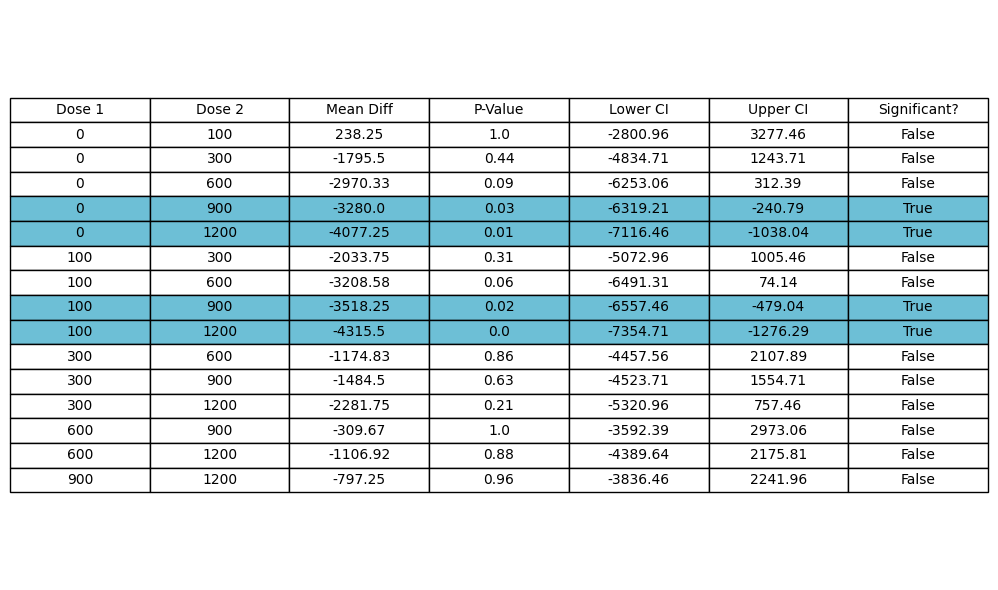

In [33]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "primary"
fig_path = save_dir / "tukey_hsd_females.png"

# create figure and axis
fig, ax = plt.subplots(figsize=(10, tukey_df.shape[0] * 0.4))
ax.axis('off')

# table plot
table = ax.table(cellText=tukey_df.values,
                 colLabels=tukey_df.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# highlight rows with significant results
for i in range(tukey_df.shape[0]):
    if tukey_df.iloc[i]['Significant?'] == True:
        for j in range(tukey_df.shape[1]):
            table[(i + 1, j)].set_facecolor("#6dbfd6")  # +1 for header offset

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()


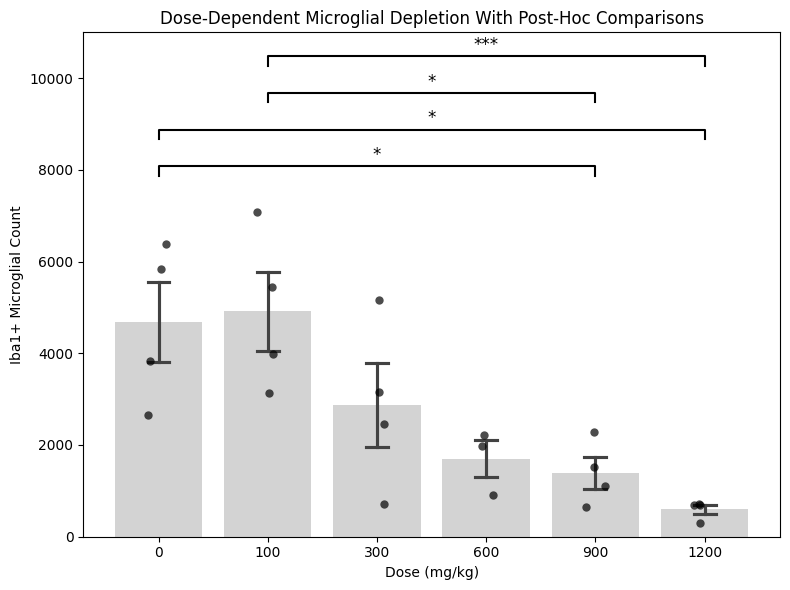

In [36]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "primary"
fig_path = save_dir / "tukey_mean_sem_females.png"

# plot Mean ± SEM per Dose
plt.figure(figsize=(8,6))
sns.barplot(
    data=female_df, 
    x="Dose", 
    y="Microglial_Count", 
    errorbar=("se", 1.0), 
    capsize=0.2, 
    color="lightgray"
)
sns.stripplot(
    data=female_df, 
    x="Dose", 
    y="Microglial_Count", 
    color="black", 
    size=6, 
    jitter=True, 
    alpha=0.7
)

# annotate Tukey Significant Comparisons 
significant_pairs = [
    (0, 900, 0.03),   # 0 vs 900
    (0, 1200, 0.01),  # 0 vs 1200
    (100, 900, 0.02), # 100 vs 900
    (100, 1200, 0.00) # 100 vs 1200
]

# y-max for placing brackets
y_max = female_df["Microglial_Count"].max()
step = 800 
current_y = y_max + step

for dose1, dose2, pval in significant_pairs:
    x1, x2 = sorted([dose1, dose2])
    # convert doses to x-axis positions 
    x1_pos = list(sorted(female_df["Dose"].unique())).index(x1)
    x2_pos = list(sorted(female_df["Dose"].unique())).index(x2)

    # draw line
    plt.plot([x1_pos, x1_pos, x2_pos, x2_pos],
             [current_y, current_y+200, current_y+200, current_y],
             color="black", linewidth=1.5)

    # add significance label
    if pval < 0.001:
        label = "***"
    elif pval < 0.01:
        label = "**"
    elif pval < 0.05:
        label = "*"
    else:
        label = f"p={pval:.2f}"
    plt.text((x1_pos+x2_pos)*0.5, current_y+250, label, ha="center", va="bottom", fontsize=12)

    current_y += step 

# plot
plt.title("Dose-Dependent Microglial Depletion With Post-Hoc Comparisons")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Iba1+ Microglial Count")

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

## Two-Way ANOVA is performed to examine the iteraction between dose and sex at the shared doses for female and male mice.

In [8]:
# perform Two-Way ANOVA on Dose x Sex at Shared Doses
shared_df = clean_df[clean_df['Dose']. isin([0, 900, 1200])]

model = ols('Microglial_Count ~ C(Dose) + C(Sex) + C(Dose):C(Sex)', data=shared_df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-Way ANOVA (Dose × Sex at Shared Doses)")
print(anova_table, "\n")

Two-Way ANOVA (Dose × Sex at Shared Doses)
                      sum_sq    df          F        PR(>F)
C(Dose)         1.066823e+08   2.0  42.506340  1.518575e-07
C(Sex)          4.633209e+06   1.0   3.692098  7.064963e-02
C(Dose):C(Sex)  3.049907e+06   2.0   1.215200  3.198605e-01
Residual        2.258818e+07  18.0        NaN           NaN 



Two-Way ANOVA at the shared doses (0, 900, 1200 mg/kg) confirmed a significant main effect of dose on microglial count (p < 0.000001), while the main effect of sex (p = 0.071) and the dose x sex interaction (p = 0.32) were not statistically significant. 

However, since male mice were only available at three doses, this analysis is limited in its ability to fully assess sex differences or interactions effects across the fully dose range. 

Additional male mice data, particularly at intermediate doses, will be necessary to more confidently evaluate whether sex influences the depltion response to PLX5622.

In [9]:
# save Two-Way ANOVA results as a CSV file
(anova_table
    .rename_axis("term")
    .reset_index()
    .to_csv(clean_dir / "twoway_ANOVA.csv", index=False))

## Visualizations for Two-Way ANOVA

#### Strip Plot for All Mice (Shared Doses)

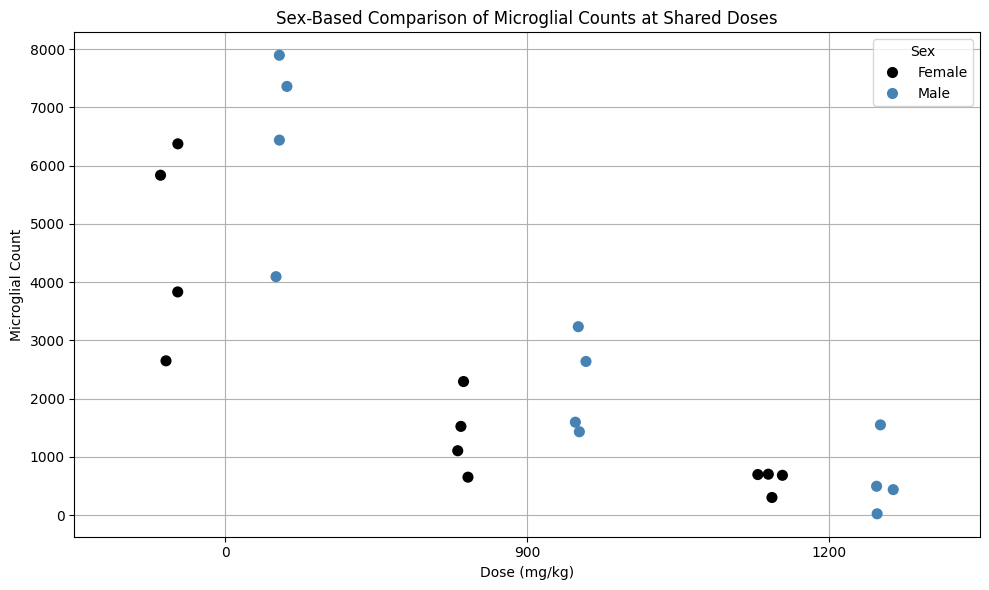

In [8]:
# filter for shared doses and include both sexes
shared_df = clean_df[clean_df["Dose"].isin([0, 900, 1200])]
# custom colors for mice
custom_colors = {"Female": "black", "Male":"steelblue"}

# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "primary"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "shared_counts_strip.png"

plt.figure(figsize=(10, 6))

sns.stripplot(data=shared_df, 
              x='Dose', 
              y='Microglial_Count', 
              hue='Sex',
              palette=custom_colors, 
              dodge=True, 
              size=8)

plt.title("Sex-Based Comparison of Microglial Counts at Shared Doses")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial Count")
plt.legend(title="Sex")
plt.grid(True)
plt.tight_layout()

plt.savefig(fig_path, dpi=300)
plt.show()

#### Overlay (Strip + Point) Plot for All Mice (Shared Doses)

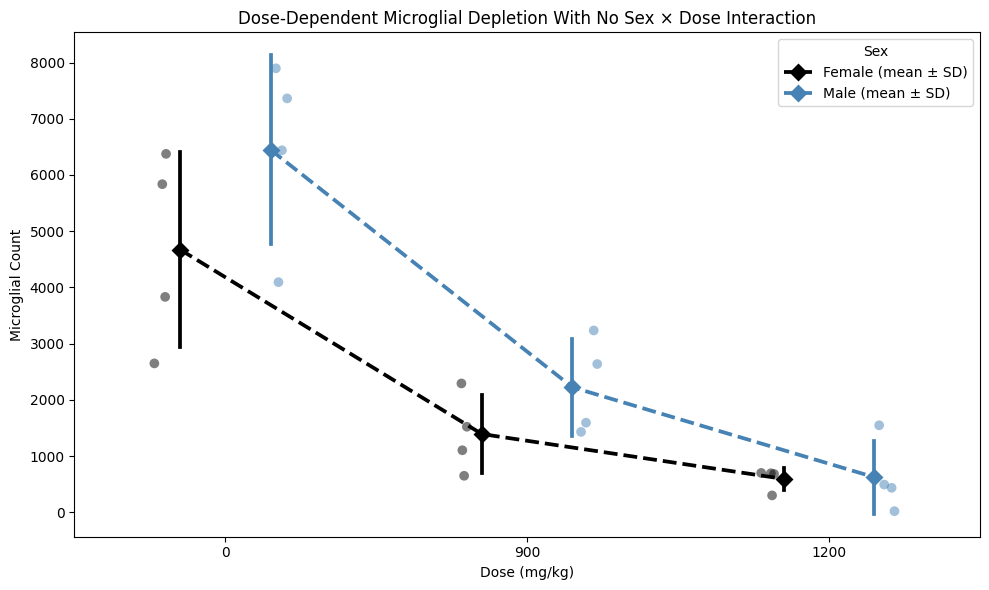

In [7]:
# where the visual will be saved
save_dir = project /"02_analysis" / "04_visualizations" / "primary"
save_dir.mkdir(parents=True, exist_ok=True)
fig_path = save_dir / "shared_counts_overlay.png"

plt.figure(figsize=(10, 6))

sns.stripplot(data=shared_df, 
              x='Dose', 
              y='Microglial_Count', 
              hue='Sex', 
              palette=custom_colors,
              dodge=True, 
              jitter=True, 
              alpha=0.5, 
              size=7,
              legend=False)

sns.pointplot(data=shared_df, 
              x='Dose', 
              y='Microglial_Count', 
              hue='Sex',
              palette=custom_colors,
              dodge=0.3, 
              errorbar='sd', 
              markers='D', 
              linestyles='--')

plt.title("Dose-Dependent Microglial Depletion With No Sex × Dose Interaction")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial Count")
plt.legend(title="Sex")

# modify legend labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, 
           labels=["Female (mean ± SD)", "Male (mean ± SD)"], 
           title="Sex")


plt.grid(False)
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

## Threshold Analysis will identify the lowest dose at which microglial counts showed biologically meaningful depletion, defined as approximately 50% deplation of microglia compared to the vehicle (Dose 0 mg/kg). This analysis is done for Female mice only due to availability across all doses.

In [10]:
print("Threshold Analysis: Mean Microglial Count by Dose (Females Only)")
threshold_table = female_df.groupby('Dose')['Microglial_Count'].agg(['mean', 'std', 'min', 'max', 'count'])
threshold_table['% Depletion from Control'] = (100 * (1 - threshold_table['mean'] / threshold_table.loc[0, 'mean']))
print(threshold_table.round(2))

Threshold Analysis: Mean Microglial Count by Dose (Females Only)
         mean      std   min   max  count  % Depletion from Control
Dose                                                               
0     4674.00  1737.17  2650  6376      4                      0.00
100   4912.25  1727.24  3144  7073      4                     -5.10
300   2878.50  1839.30   720  5167      4                     38.41
600   1703.67   694.93   912  2213      3                     63.55
900   1394.00   697.71   652  2294      4                     70.18
1200   596.75   195.99   303   703      4                     87.23


Threshold analysis was conducted to determine the lowest PLX5622 dose at which average microglial depletion became biologically meaningful. Group means (average microglial counts per slice) were used for this analysis. Female vehicle animals averaged 4,674 ± 1,737 cells per slice, while those treated with 1200 mg/kg averaged 597 ± 196 cells. This corresponded to an ~87% depletion at the highest dose. Approximately, ~50% depletion was achieved between 300 mg/kg (38% depletion) and 600 mg/kg (64% depletion), indicating that biologically meaningful depletion occurs beginning at 600 mg/kg.

In [11]:
# save Threshold Analysis results as a CSV file
threshold_table.round(2).to_csv(clean_dir / "threshold_analysis.csv", index=True, index_label="Dose")

## Visualization for Threshold Analysis

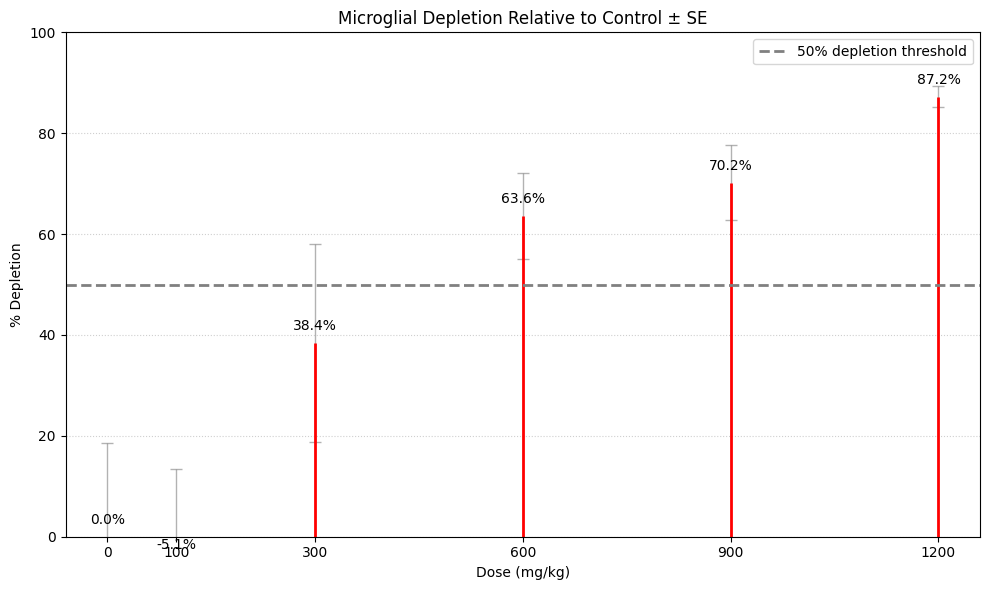

In [38]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "primary"
fig_path = save_dir / "threshold_SE.png"

# defining values
dose_levels = [0, 100, 300, 600, 900, 1200]
percent_depletion = [0.0, -5.10, 38.41, 63.55, 70.18, 87.23]

# calculate SE 
threshold_table['SE'] = threshold_table['std'] / np.sqrt(threshold_table['count'])
control_mean = threshold_table.loc[0, 'mean']
threshold_table['SE_%'] = 100 * threshold_table['SE'] / control_mean

# create figure
plt.figure(figsize=(10, 6))

for dose, percent in zip(
    threshold_table.index,
    threshold_table['% Depletion from Control']):
    # plot each depletion as a red vertical line
    plt.vlines(x=dose, ymin=0, ymax=percent, colors='red', linewidth=2)
    # label above the endpoint
    plt.text(dose, percent + 2, f"{percent:.1f}%", ha='center', va='bottom')

# SE bars
plt.errorbar(
    threshold_table.index,
    threshold_table['% Depletion from Control'],
    yerr=threshold_table['SE_%'],
    fmt='none', ecolor='gray', elinewidth=1, alpha=0.6, capsize=4, zorder=1)

# add 50% depletion reference line
plt.axhline(y=50, color='gray', linestyle='--', linewidth=2, label='50% depletion threshold')

# plot
plt.title("Microglial Depletion Relative to Control ± SE")
plt.xlabel("Dose (mg/kg)")
plt.ylabel("% Depletion")
plt.ylim(0, 100)  
plt.xticks(threshold_table.index)
plt.legend()
plt.grid(True, axis='y', linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()